(3000, 3)

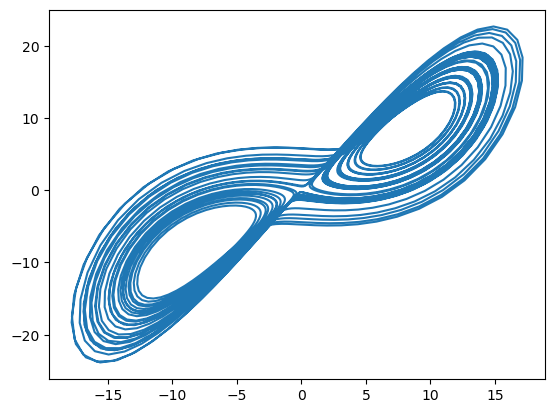

In [26]:
# in this notebook we're going to make sure the dynamic quantities are correct by evaluating them on two different
# versions of a particular chaotic attractor: delay embedded reconstruction or high dimensional embedding with linear layers

import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz, Rossler
import torch

## Load and simulate an attractor
attractor = Lorenz()
sol = attractor.make_trajectory(3000, resample=True, noise=0.0)
sol += np.random.random(sol.shape) * 0.0
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
# sol = sol[::10]
sol.shape

In [13]:
# create the delay embedding
x = sol[:, 0]

n_delays = 10
delay_interval = 1

# create delay embedding
H = np.array(
    [
        x[i : i + n_delays * delay_interval : delay_interval]
        for i in range(x.shape[0] - n_delays * delay_interval)
    ]
)

print(H.shape)

(2990, 10)


In [27]:
null_attractor = Rossler()
null_sol = null_attractor.make_trajectory(3000, resample=True, noise=0.0)
null_sol += np.random.random(null_sol.shape) * 0.0

In [14]:
def kullback_leibler_divergence(p1, p2):
    """
    Calculate Kullback-Leibler divergence
    """
    if p1 is None or p2 is None:
        kl = torch.tensor([float("nan")])
    else:
        kl = (p1 * torch.log(p1 / p2)).sum()
    return kl


def calc_histogram(x, n_bins, min_, max_):
    """
    Calculate a multidimensional histogram in the range of min and max
    works by aggregating values in sparse tensor,
    then exploits the fact that sparse matrix indices may contain the same coordinate multiple times,
    the matrix entry is then the sum of all values at the coordinate
    for reference: https://discuss.pytorch.org/t/histogram-function-in-pytorch/5350/9
    Outliers are discarded!
    :param x: multidimensional data: shape (N, D) with N number of entries, D number of dims
    :param n_bins: number of bins in each dimension
    :param min_: minimum value
    :param max_: maximum value to consider for histogram
    :return: histogram
    """
    # convert x to torch tensor
    x = torch.from_numpy(x)
    dim_x = x.shape[1]  # number of dimensions

    coordinates = (n_bins * (x - min_) / (max_ - min_)).long()

    # discard outliers
    coord_bigger_zero = coordinates > 0
    coord_smaller_nbins = coordinates < n_bins
    inlier = coord_bigger_zero.all(1) * coord_smaller_nbins.all(1)
    coordinates = coordinates[inlier]

    size_ = tuple(n_bins for _ in range(dim_x))
    indices = torch.ones(coordinates.shape[0], device=coordinates.device)
    if "cuda" == coordinates.device.type:
        tens = torch.cuda.sparse.FloatTensor
    else:
        tens = torch.sparse.FloatTensor
    return tens(coordinates.t(), indices, size=size_).to_dense()


def get_min_max_range(x_true):
    std = x_true.std(0)
    return -2 * std, 2 * std


def normalize_to_pdf_with_laplace_smoothing(histogram, n_bins, smoothing_alpha=10e-6):
    if histogram.sum() == 0:  # if no entries in the range
        pdf = None
    else:
        dim_x = len(histogram.shape)
        pdf = (histogram + smoothing_alpha) / (
            histogram.sum() + smoothing_alpha * n_bins**dim_x
        )
    return pdf


def get_pdf_from_timeseries(x_gen, x_true, n_bins):
    """
    Calculate spatial pdf of time series x1 and x2
    :param x_gen: multivariate time series: shape (T, dim)
    :param x_true: multivariate time series, used for choosing range of histogram
    :param n_bins: number of histogram bins
    :return: pdfs
    """
    min_, max_ = get_min_max_range(x_true)
    hist_gen = calc_histogram(x_gen, n_bins=n_bins, min_=min_, max_=max_)
    hist_true = calc_histogram(x_true, n_bins=n_bins, min_=min_, max_=max_)

    p_gen = normalize_to_pdf_with_laplace_smoothing(histogram=hist_gen, n_bins=n_bins)
    p_true = normalize_to_pdf_with_laplace_smoothing(histogram=hist_true, n_bins=n_bins)
    return p_gen, p_true


def klx_metric(x_gen, x_true, n_bins=30):
    # plot_kl(x_gen, x_true, n_bins)
    p_gen, p_true = get_pdf_from_timeseries(x_gen, x_true, n_bins)
    return kullback_leibler_divergence(p_true, p_gen), p_gen, p_true

Text(0.5, 1.0, 'Rossler vs Lorenz: KL: 2.956712007522583')

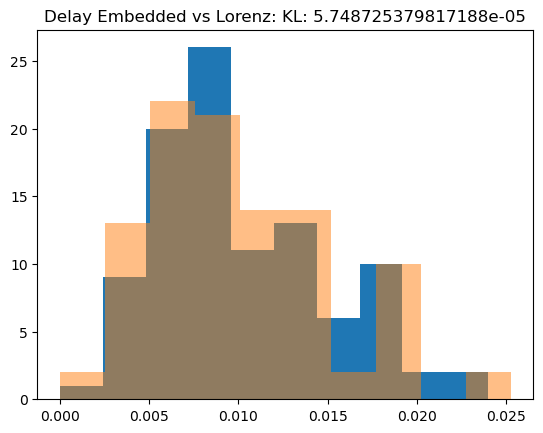

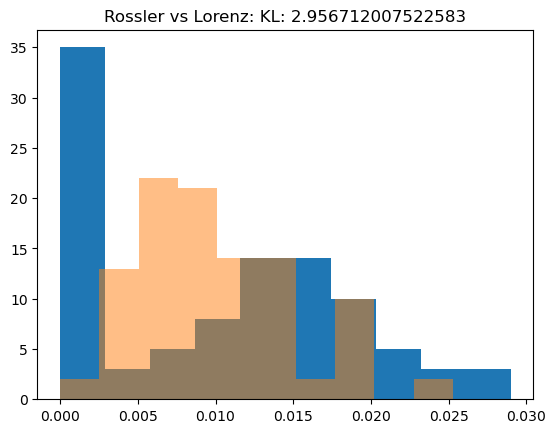

In [32]:
x_gen = H[:, 0:1]  # sol[:sol.shape[0]//2,0:1]
x_true = sol[:, 0:1]  # sol[sol.shape[0]//2:,0:1]

kl, p_gen, p_true = klx_metric(x_gen, x_true, n_bins=100)
plt.hist(p_gen)
plt.hist(p_true, alpha=0.5)
plt.title(f"Delay Embedded vs Lorenz: KL: {kl.item()}")


# do the same fore null_sol and sol
x_gen = null_sol[:, 0:1]  # sol[:sol.shape[0]//2,0:1]
x_true = sol[:, 0:1]  # sol[sol.shape[0]//2:,0:1]
kl, p_gen, p_true = klx_metric(x_gen, x_true, n_bins=100)
plt.figure()
plt.hist(p_gen)
plt.hist(p_true, alpha=0.5)
plt.title(f"Rossler vs Lorenz: KL: {kl.item()}")

In [33]:
# now, test the spectral correlation
def convert_to_decibel(x):
    x = 20 * np.log10(x)
    return x[0]


def ensure_length_is_even(x):
    n = len(x)
    if n % 2 != 0:
        x = x[:-1]
        n = len(x)
    x = np.reshape(x, (1, n))
    return x


from scipy.ndimage import gaussian_filter1d


def fft_in_decibel(x, smoothing):
    """
    Originally by: Vlachas Pantelis, CSE-lab, ETH Zurich in https://github.com/pvlachas/RNN-RC-Chaos
    Calculate spectrum in decibel scale,
    scale the magnitude of FFT by window and factor of 2, because we are using half of FFT spectrum.
    :param x: input signal
    :return fft_decibel: spectrum in decibel scale
    """
    x = ensure_length_is_even(x)
    fft_real = np.fft.rfft(x)
    fft_magnitude = np.abs(fft_real) * 2 / len(x)
    fft_decibel = convert_to_decibel(fft_magnitude)

    fft_smoothed = gaussian_filter1d(fft_decibel, sigma=smoothing)
    return fft_smoothed


def get_average_spectrum(trajectories, smoothing):
    spectrum = []
    for trajectory in trajectories:
        trajectory = (
            trajectory - trajectory.mean()
        ) / trajectory.std()  # normalize individual trajectories
        fft_decibel = fft_in_decibel(trajectory, smoothing)
        spectrum.append(fft_decibel)
    spectrum = np.array(spectrum).mean(axis=0)
    return spectrum


def power_spectrum_error_per_dim(x_gen, x_true, smoothing, cutoff):
    # if x_true.shape[0] == 99:
    #     x_gen = x_gen[:, :99000, :]
    # print(x_true.shape)
    x_true = x_true.reshape(x_gen.shape)

    assert x_true.shape[1] == x_gen.shape[1]
    assert x_true.shape[2] == x_gen.shape[2]
    dim_x = x_gen.shape[2]
    pse_corrs_per_dim = []
    for dim in range(dim_x):
        spectrum_true = get_average_spectrum(x_true[:, :, dim], smoothing)
        spectrum_gen = get_average_spectrum(x_gen[:, :, dim], smoothing)
        spectrum_true = spectrum_true[:cutoff]
        spectrum_gen = spectrum_gen[:cutoff]
        # if plot_save_dir is not None:
        #     plot_spectrum_comparison(spectrum_true=spectrum_true, spectrum_gen=spectrum_gen,
        #                              plot_save_dir=plot_save_dir)
        pse_corr_per_dim = np.abs(np.corrcoef(x=spectrum_gen, y=spectrum_true)[0, 1])
        pse_corrs_per_dim.append(pse_corr_per_dim)
    return pse_corrs_per_dim

In [35]:
power_spectrum_error_per_dim(
    sol[None, : sol.shape[0] // 2],
    sol[None, sol.shape[0] // 2 :],
    smoothing=1,
    cutoff=100,
)

[0.9868205772117585, 0.990078813652411, 0.9863843419985205]

[0.9682208755256274]

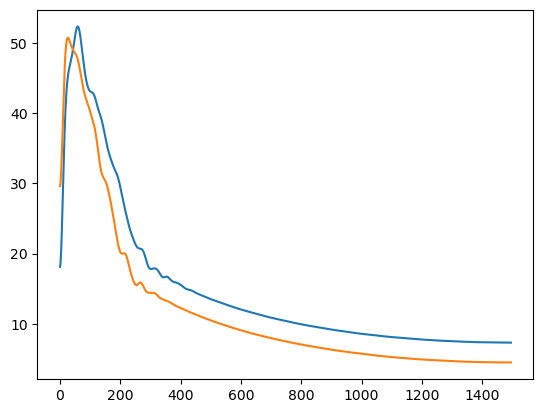

In [43]:
x_gen = H[np.newaxis, :, 1:2]  # sol[:sol.shape[0]//2,0:1]
x_true = sol[np.newaxis, n_delays:, 2:3]  # sol[sol.shape[0]//2:,0:1]
dim = 0
smoothing = 10

spectrum_true = get_average_spectrum(x_true[:, :, dim], smoothing)
spectrum_gen = get_average_spectrum(x_gen[:, :, dim], smoothing)
plt.plot(spectrum_true)
plt.plot(spectrum_gen)

power_spectrum_error_per_dim(x_gen, x_true, smoothing=1, cutoff=1000)